In [1]:
import pickle
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from model import TrainMgr
from utils import *

In [2]:
with open('MAPS_logmel229/train.p', 'rb') as f:
    [x_list, y_list, na_list] = pickle.load(f, encoding='latin-1')
# x_list: [(N1, 229), (N2, 229), ...]
# y_list: [(N1, 88), (N2, 88), ...]
# na_list: list of names. 

x_list_train, x_list_test, y_list_train, y_list_test = train_test_split(x_list, y_list, test_size=0.2)

X_train = np.concatenate(x_list_train, axis=0)
X_test = np.concatenate(x_list_test, axis=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.concatenate(y_list_train, axis=0)
y_test = np.concatenate(y_list_test, axis=0)

y_list_train_torch = [torch.FloatTensor(y) for y in y_list_train]
y_list_test_torch = [torch.FloatTensor(y) for y in y_list_test]

dataset_train = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
dataset_test = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

In [3]:
# to_plot = np.random.choice(len(x_list), 10)
# for i in to_plot:
#     fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=2)    
#     ax = axes[0]
#     ax.imshow(x_list[i].T, aspect='auto')
#     ax.invert_yaxis()
    
#     ax = axes[1]
#     ax.imshow(y_list[i].T, aspect='auto')
#     ax.invert_yaxis()

#     plt.suptitle(na_list[i])
#     plt.show()

In [4]:
config_acoustic = {
    'input_size': 229,
    'hidden_size': 512,
    'n_layers': 4,
    'output_size': 88,
    'activation': 'ReLU',
    'p': 0.25,
    'batch_size': 500,
    'lr': 0.01,
}

config_language = {
    'input_size': 88,
    'hidden_size': 128,
    'n_layers': 2,
    'output_size': 88,
    'batch_size': 100,
    'lr': 0.01,
}

mgr = TrainMgr(config_acoustic, config_language, save_every=5)

In [5]:
# mgr.train_language(y_list_train_torch, 5)
language_model = mgr.language_model
language_model.load_state_dict(torch.load('flat_acoustic_language/language_model_20_bk.pt'))
mgr.language_model = language_model

In [6]:
# mgr.train_acoustic(dataset_train, 5)
acoustic_model = mgr.acoustic_model
acoustic_model.load_state_dict(torch.load('flat_acoustic_language/acoustic_model_20_bk.pt'))
mgr.acoustic_model = acoustic_model

In [7]:
### RUN BELOW TO ESTIMATE OPTIMAL THRESHOLD WITH GREEDY DECODING

# N_check = 20
# idx_check = np.random.choice(len(x_list_train), N_check)
# ys = []
# y_pred = []

# with tqdm(total=N_check) as pbar:
#     for idx in idx_check:
#         x = x_list_train[idx]
#         y = y_list_train[idx]
#         x = torch.FloatTensor(scaler.transform(x))
#         ys.append(y)
#         y_pred.append(greedy_decoding(x, acoustic_model, language_model))
#         pbar.update(1)
        
# thresholds = [0.0095, 0.0098, 0.01, 0.012, 0.015, 0.02]    
# accs = np.empty((len(thresholds), len(ys)))
# for i, thres in enumerate(thresholds):
#     for j, (y, y_gt) in enumerate(zip(y_pred, ys)):
#         _, _, acc, _ = prec_recall_fvalue(
#             y.data.cpu().numpy().T, y_gt.T, thres=thres, average='micro'
#         )
#         accs[i, j] = acc
        
# total_acc = np.mean(accs, axis=1)
# thresholds[np.argmax(total_acc)]

thres = 0.01

In [ ]:
sample_rate = 4000
n_step = 512
step_sec = float(n_step) / sample_rate

In [9]:
def save_midi(filename, thres):
    idx = [i for i, file in enumerate(na_list) if filename in file]
    assert len(idx) == 1
    idx = idx[0]
    
    mid_roll = prob_to_midi_roll(y_list[idx], 0.5)
    out_path = 'MIDI/{:s}.mid'.format(filename)
    write_midi_roll_to_midi(mid_roll, out_path)
    
    x = torch.FloatTensor(scaler.transform(x_list[idx]))
#     y_pred = mgr.acoustic_model(x).data.cpu().numpy()
    
    y_pred = greedy_decoding(x, mgr.acoustic_model, mgr.language_model)[:500] 
    mid_roll = prob_to_midi_roll(y_pred, thres)
    out_path = 'MIDI/{:s}.mid'.format('{}_pred'.format(filename))
    write_midi_roll_to_midi(mid_roll, out_path)

In [11]:
# filename = 'MAPS_MUS-chpn_op66_AkPnBcht'
# filename = 'MAPS_MUS-bach_850_AkPnBsdf'
filename = 'MAPS_MUS-chpn-p10_AkPnStgb'
save_midi(filename, thres)

In [11]:
# !timidity MAPS_MUS-chpn_op66_AkPnBcht.mid
# !timidity MAPS_MUS-chpn_op66_AkPnBcht_pred.mid

In [8]:
dataset_test = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
loader = DataLoader(dataset_test, batch_size=int(5e4), shuffle=False)
acc, fvalue = batch_metrics_greedy_decoding(
    loader, 
    mgr.acoustic_model, 
    mgr.language_model, 
    thres=thres, 
    average='micro'
)
    
print('Accuracy: {:.2%}'.format(acc))
print('F score: {:.2%}'.format(fvalue))

# dataset_test_random = TensorDataset(torch.randn(X_test.shape), torch.FloatTensor(y_test))
# loader_random = DataLoader(dataset_test_random, batch_size=int(5e4), shuffle=False)
# acc_random, fvalue_random = batch_metrics(loader_random, mgr.acoustic_model, average='macro')
# print('Accuracy (random): {:.2%}'.format(acc_random))

100%|██████████| 8/8 [06:07<00:00, 45.90s/it]

Accuracy: 27.35%
F score: 42.76%


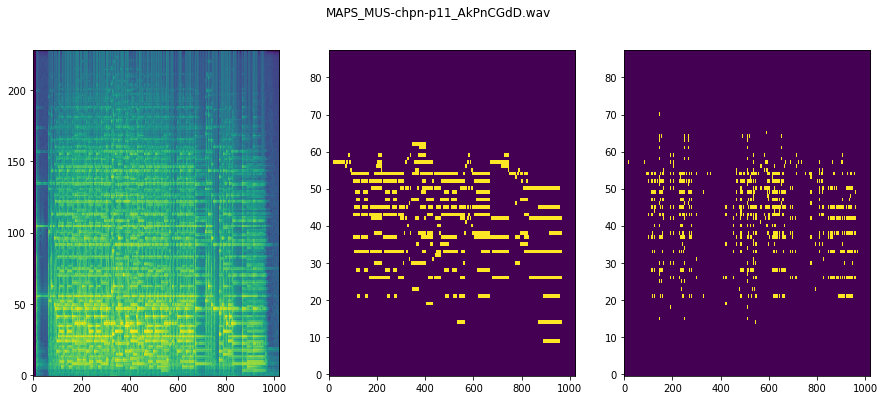

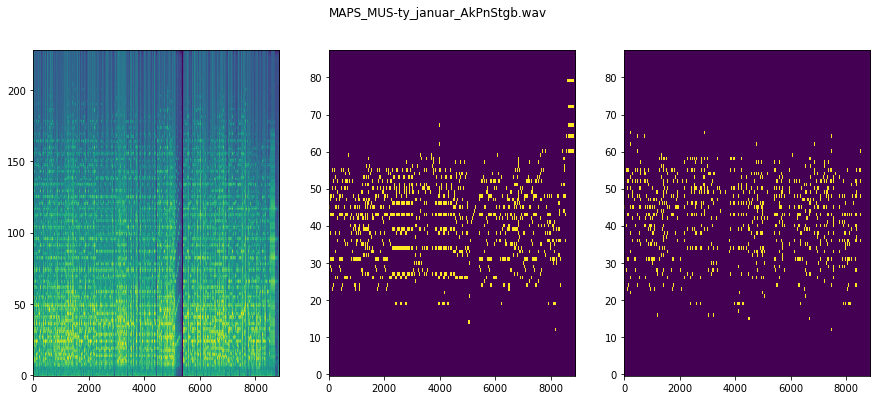

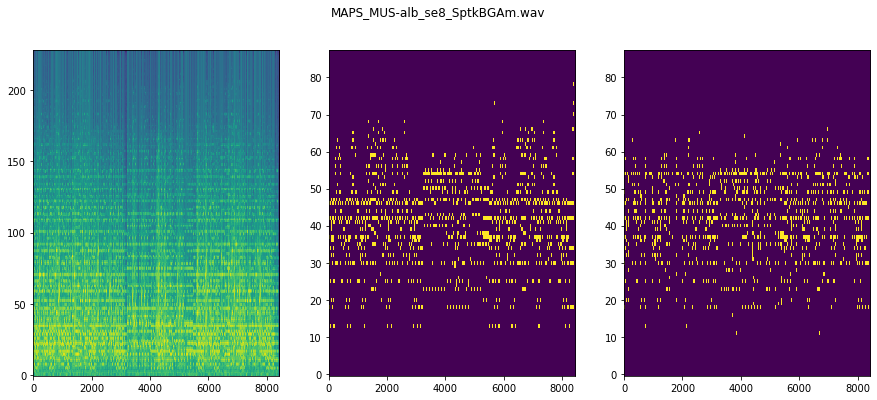

In [13]:
mgr.acoustic_model.eval()

to_plot = np.random.choice(len(x_list), 3)
for idx in to_plot:
    fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=3)    
    ax = axes[0]
    ax.imshow(x_list[idx].T, aspect='auto')
    ax.invert_yaxis()
    
    ax = axes[1]
    ax.imshow(y_list[idx].T, aspect='auto')
    ax.invert_yaxis()

    x = torch.FloatTensor(scaler.transform(x_list[idx]))
#     y_pred = mgr.acoustic_model(x).data.cpu().numpy()
    y_pred = greedy_decoding(x, mgr.acoustic_model, mgr.language_model).data.cpu().numpy()
    
    ax = axes[2]
    ax.imshow((y_pred>thres).T, aspect='auto')
    ax.invert_yaxis()

    plt.suptitle(na_list[idx])
    plt.show()

In [14]:
# for idx in to_plot:
#     fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=3)    
#     ax = axes[0]
#     ax.imshow(x_list[idx].T, aspect='auto')
#     ax.invert_yaxis()
    
#     ax = axes[1]
#     ax.imshow(y_list[idx].T, aspect='auto')
#     ax.invert_yaxis()

#     x = torch.FloatTensor(scaler.transform(x_list[idx]))
#     y_pred = mgr.acoustic_model(x).data.cpu().numpy()
    
#     ax = axes[2]
#     ax.imshow((y_pred).T, aspect='auto')
#     ax.invert_yaxis()

#     plt.suptitle(na_list[idx])